# feature_extraction

## 1. define arguments for code execution

In [1]:
# arguments for code execution
arg_user = 'OREN'                        # OREN, TOM
arg_predictor_path = '../Utils/Predictors/shape_predictor_68_face_landmarks.dat'

# arguments for video
arg_video_name = 'normal_01_n_30fps.mp4' # palsy/normal_xx_y_zzfps.mp4 (xx = video index, y = palsy eye (l/r/n), zz = fps)
arg_window_len_sec = 2                   # sliding windows length (in seconds) for score normalization

# feature selection ׂ(0 - not active, 1 - active)
arg_features = {'palsy_eye':1,'1-r^2':1,'ellipse_a':1,'poly_a':1,'ear':1}

In [2]:
# define constants
precision_digits = 2                     # precision for floats (number of digits after fix point)

# define color list
c_red = (0,0,255)
c_cyan = (255,255,0)
c_magenta = (255,0,255)
c_silver = (192,192,192)
c_lime = (0,255,0)
c_purple = (128,0,128)
c_yellow = (0,255,255)
c_white = (255,255,255)
c_black = (0,0,0)
c_blue = (255,0,0)

colors = [c_red,c_cyan,c_magenta,c_silver,c_lime,c_purple,c_yellow,c_white,c_black,c_blue]

# define text position lists
text_pos_r = []
text_pos_m = []
text_pos_l = []
text_pos_gap = 15

for i in range(0,10):
    text_pos_r.append((10,30+i*text_pos_gap))
    text_pos_m.append((10,15+i*text_pos_gap))
    text_pos_l.append((300,30+i*text_pos_gap))

## 2. import packagers and libraries

In [3]:
# import OpenCV path
import sys
if (arg_user == 'OREN'):
    sys.path.append('D:\Softwares\Anaconda3\envs\opencv-env\Lib\site-packages')
else:
    sys.path.append('C:/Users/user/Anaconda3/envs/opencv-env/Lib/site-packages')

In [4]:
# import necessary packages
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
from scipy.spatial import distance as dist
import pandas as pd
import numpy as np
import math
import random
import argparse
import imutils
import time
import dlib
import cv2
import os

In [5]:
# calcultate parameters from arguments
video_path = 'files/input/' + arg_video_name

video_index = arg_video_name[-14:-12]
video_fps = int(arg_video_name[-9:-7])
video_palsy_eye = arg_video_name[-11]

window_len_frame = math.ceil(video_fps * arg_window_len_sec)

In [6]:
# create sub folders for outputs
output_path = "files/output/" + arg_video_name[:-4]
output_path_frames_features = "files/output/" + arg_video_name[:-4] + "/frames_features"
output_path_frames_for_tag = "files/output/" + arg_video_name[:-4] + "/frames_for_tag"

if not os.path.exists(output_path):
    os.makedirs(output_path)
if not os.path.exists(output_path_frames_features):
    os.makedirs(output_path_frames_features)
if not os.path.exists(output_path_frames_for_tag):
    os.makedirs(output_path_frames_for_tag)
    
output_path_full = output_path + "/" + arg_video_name[:-4]

## 3. define function for feature extraction

In [7]:
# calculate eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of vertical eye landmarks (x,y) coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    # compute the euclidean distance between the horizontal eye landmark (x,y) coordinates
    C = dist.euclidean(eye[0], eye[3])
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    # return the eye aspect ratio
    return ear

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# calculate R^2 score for P1, P2, P3 and P4
def calc_r2(eye):
    x = eye[0:4,0]
    y = eye[0:4,1]
    X = x[:, np.newaxis]
    linreg = LinearRegression()
    linreg.fit(X,y)
    y_pred = linreg.predict(X)
    return [X, y_pred, 1 - r2_score(y, y_pred)]

In [9]:
# calculate the matched elipse area
def calc_ellipse_area(eye):
    (xe, ye), (MA, ma), angle = cv2.fitEllipse(eye)
    A = np.pi * MA * ma
    return A

In [10]:
# calculate the area of a polygon defined by (x,y) coordinates using Shoelace formula
def poly_area(eye):
    x = eye[:,0]
    y = eye[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

## 4. normalize feature score for current frame

In [11]:
# normalize score based on min and max values
def normalize_score(curr_score, min_score, max_score, precision_digits):
    normalized_score = (curr_score - min_score) / (max_score - min_score)
    if normalized_score > 1.0:
        normalized_score = 1.0
    elif normalized_score < 0.0:
        normalized_score = 0.0
    
    return round(float(normalized_score) ,precision_digits)

In [12]:
# normalize feature score for current frame based on the latest scores
def normalize_feature_score(frame_number, window_len_frame, video_palsy_eye, curr_feature, df_left_scores, df_right_scores, curr_left_score, curr_right_score, precision_digits):
    # if frame number smaller than sliding window length - assign NaN values
    if frame_number < window_len_frame - 1:
        curr_left_score_normalized = float('NaN')
        curr_right_score_normalized = float('NaN')
    # else, normalize feature score for current frame based on the latest scores
    else:
        min_left_score = float(min(np.nanmin(df_left_scores[curr_feature][-(window_len_frame-1):]),curr_left_score))
        max_left_score = float(max(np.nanmax(df_left_scores[curr_feature][-(window_len_frame-1):]),curr_left_score))
        min_right_score = float(min(np.nanmin(df_right_scores[curr_feature][-(window_len_frame-1):]),curr_right_score))
        max_right_score = float(max(np.nanmax(df_right_scores[curr_feature][-(window_len_frame-1):]),curr_right_score))
        
        # if there is palsy eye, normalize it according to healty eye
        if (video_palsy_eye == 'l'):
            curr_left_score_normalized = normalize_score(curr_left_score, min_right_score, max_right_score, precision_digits)
            curr_right_score_normalized = normalize_score(curr_right_score, min_right_score, max_right_score, precision_digits)
        elif (video_palsy_eye == 'r'):
            curr_left_score_normalized = normalize_score(curr_left_score, min_left_score, max_left_score, precision_digits)
            curr_right_score_normalized = normalize_score(curr_right_score, min_left_score, max_left_score, precision_digits)
        else:
            curr_left_score_normalized = normalize_score(curr_left_score, min_left_score, max_left_score, precision_digits)
            curr_right_score_normalized = normalize_score(curr_right_score, min_right_score, max_right_score, precision_digits)
    
    # return values
    return [curr_left_score_normalized, curr_right_score_normalized]

## 5. feature extraction from video

In [13]:
# initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(arg_predictor_path)

In [14]:
# grab the indexes of the facial landmarks for the left and right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [15]:
# initialize column for dataframes of scores for both eyes
df_column = ['frame_name']

for feature in arg_features.keys():
    if (arg_features[feature] == 1):
        df_column.append(feature)

# start the video stream thread
print("[INFO] starting video stream thread...")
vs = FileVideoStream(video_path).start()
fileStream = True
time.sleep(1.0)
frame_number = 0

# loop over frames from the video stream
while True:
    # if this is a file video stream, then we need to check if there any more frames left in the buffer to process
    if fileStream and not vs.more():
        break

    # grab the frame from the threaded video file stream, resize it, and convert it to grayscale channels
    frame = vs.read()
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale frame
    rects = detector(gray, 0)
    
    # frame name
    frame_name = arg_video_name[:-4]+'_frame'+"{:04d}".format(frame_number)
    
    # show frame name and elapsed time
    elapsed_time = frame_number / video_fps
    cv2.putText(frame, frame_name+", T = {:.2f} Sec".format(elapsed_time), text_pos_m[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[-1], 2)
    
    # save frame to frames_for_tag
    cv2.imwrite(output_path_frames_for_tag+"/"+frame_name+".jpg", frame)
    
    if (len(rects) != 1):
        # Notice about faces number on current frame
        cv2.putText(frame, "{:d} faces detected!".format(len(rects)), text_pos_m[1], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[-1], 2)
        
        # prepare NaN raw for current frame
        df_nan_row = [frame_name]+[float('NaN')]*(len(df_column)-1)
        
        # create new Dataframe for first frame, otherwise concatenate to exist DataFrame
        if (frame_number == 0):
            df_left_scores = pd.DataFrame([df_nan_row],columns = df_column)
            df_right_scores = pd.DataFrame([df_nan_row],columns = df_column)
            df_left_scores_normalized = pd.DataFrame([df_nan_row],columns = df_column)
            df_right_scores_normalized = pd.DataFrame([df_nan_row],columns = df_column)
        else:
            df_left_scores = pd.concat([df_left_scores, pd.DataFrame([df_nan_row],columns = df_column)])
            df_right_scores = pd.concat([df_right_scores, pd.DataFrame([df_nan_row],columns = df_column)])
            df_left_scores_normalized = pd.concat([df_left_scores_normalized, pd.DataFrame([df_nan_row],columns = df_column)])
            df_right_scores_normalized = pd.concat([df_right_scores_normalized, pd.DataFrame([df_nan_row],columns = df_column)])
        
    else:
        # loop over the face detections
        for rect in rects:
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x,y) coordinates to a NumPy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # extract the left and right eye coordinates, then use the
            # coordinates to compute the eye aspect ratio for both eyes
            left_eye_shape = shape[lStart:lEnd]
            right_eye_shape = shape[rStart:rEnd]
            
            # initialize rows for DataFrames
            df_left_row = [frame_name]
            df_right_row = [frame_name]
            df_left_row_normalized = [frame_name]
            df_right_row_normalized = [frame_name]
            
            # feature index
            feature_index = 0
            
            # calculate relevant features (skip first object - 'frame_name')
            for feature in df_column[1:]:
                
                curr_feature = 'palsy_eye'
                if feature == curr_feature:
                    # 1. calculate values
                    curr_left_score = round(float(video_palsy_eye == 'l'),precision_digits)
                    curr_right_score = round(float(video_palsy_eye == 'r'),precision_digits)
                    # 2. append to row for data prame
                    df_left_row.append(curr_left_score)
                    df_right_row.append(curr_right_score)
                    # 3. calculate normalized values
                    curr_left_score_normalized = curr_left_score
                    curr_right_score_normalized = curr_right_score
                    # 4. append to row for normalized data frame
                    df_left_row_normalized.append(curr_left_score_normalized)
                    df_right_row_normalized.append(curr_right_score_normalized)
                    # 5. print feature score
                    cv2.putText(frame, "R_"+curr_feature+": {:.2f}".format(curr_right_score_normalized), 
                                text_pos_r[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    cv2.putText(frame, "L_"+curr_feature+": {:.2f}".format(curr_left_score_normalized), 
                                text_pos_l[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    # 6. draw feature patterns
                
                curr_feature = 'ear'
                if feature == curr_feature:
                    # 1. calculate values
                    curr_left_score = eye_aspect_ratio(left_eye_shape)
                    curr_right_score = eye_aspect_ratio(right_eye_shape)
                    # 2. append to row for data prame
                    df_left_row.append(curr_left_score)
                    df_right_row.append(curr_right_score)
                    # 3. calculate normalized values
                    if (frame_number == 0):
                        curr_left_score_normalized = float('NaN')
                        curr_right_score_normalized = float('NaN')
                    else:
                        [curr_left_score_normalized, curr_right_score_normalized] = normalize_feature_score(frame_number,
                                                                                    window_len_frame,
                                                                                    video_palsy_eye,df_column[feature_index+1],
                                                                                    df_left_scores,df_right_scores,
                                                                                    curr_left_score,curr_right_score,
                                                                                    precision_digits)
                    # 4. append to row for normalized data frame
                    df_left_row_normalized.append(curr_left_score_normalized)
                    df_right_row_normalized.append(curr_right_score_normalized)
                    # 5. print feature score
                    cv2.putText(frame, "R_"+curr_feature+": {:.2f}".format(curr_right_score_normalized), 
                                text_pos_r[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    cv2.putText(frame, "L_"+curr_feature+": {:.2f}".format(curr_left_score_normalized), 
                                text_pos_l[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    # 6. draw feature patterns
                    for (x,y) in right_eye_shape:
                        cv2.circle(frame, (x,y), 1, colors[feature_index], -1)
                    for (x,y) in left_eye_shape:
                        cv2.circle(frame, (x,y), 1, colors[feature_index], -1)
                    
                curr_feature = '1-r^2'
                if feature == curr_feature:
                    # 1. calculate values
                    [x_left, y_pred_left, curr_left_score] = calc_r2(left_eye_shape)
                    [x_right, y_pred_right, curr_right_score] = calc_r2(right_eye_shape)
                    # 2. append to row for data prame
                    df_left_row.append(curr_left_score)
                    df_right_row.append(curr_right_score)
                    # 3. calculate normalized values
                    if (frame_number == 0):
                        curr_left_score_normalized = float('NaN')
                        curr_right_score_normalized = float('NaN')
                    else:
                        [curr_left_score_normalized, curr_right_score_normalized] = normalize_feature_score(frame_number,
                                                                                    window_len_frame,
                                                                                    video_palsy_eye,df_column[feature_index+1],
                                                                                    df_left_scores,df_right_scores,
                                                                                    curr_left_score,curr_right_score,
                                                                                    precision_digits)
                    # 4. append to row for normalized data frame
                    df_left_row_normalized.append(curr_left_score_normalized)
                    df_right_row_normalized.append(curr_right_score_normalized)
                    # 5. print feature score
                    cv2.putText(frame, "R_"+curr_feature+": {:.2f}".format(curr_right_score_normalized), 
                                text_pos_r[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    cv2.putText(frame, "L_"+curr_feature+": {:.2f}".format(curr_left_score_normalized), 
                                text_pos_l[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    # 6. draw feature patterns
                    cv2.line(frame,(int(x_left[0]),int(y_pred_left[0])),(int(x_left[-1]),int(y_pred_left[-1])),colors[feature_index],1)
                    cv2.line(frame,(int(x_right[0]),int(y_pred_right[0])),(int(x_right[-1]),int(y_pred_right[-1])),colors[feature_index],1)
                    
                curr_feature = 'ellipse_a'
                if feature == curr_feature:
                    # 1. calculate values
                    curr_left_score = calc_ellipse_area(left_eye_shape)
                    curr_right_score = calc_ellipse_area(right_eye_shape)
                    # 2. append to row for data prame
                    df_left_row.append(curr_left_score)
                    df_right_row.append(curr_right_score)
                    # 3. calculate normalized values
                    if (frame_number == 0):
                        curr_left_score_normalized = float('NaN')
                        curr_right_score_normalized = float('NaN')
                    else:
                        [curr_left_score_normalized, curr_right_score_normalized] = normalize_feature_score(frame_number,
                                                                                    window_len_frame,
                                                                                    video_palsy_eye,df_column[feature_index+1],
                                                                                    df_left_scores,df_right_scores,
                                                                                    curr_left_score,curr_right_score,
                                                                                    precision_digits)
                    # 4. append to row for normalized data frame
                    df_left_row_normalized.append(curr_left_score_normalized)
                    df_right_row_normalized.append(curr_right_score_normalized)
                    # 5. print feature score
                    cv2.putText(frame, "R_"+curr_feature+": {:.2f}".format(curr_right_score_normalized), 
                                text_pos_r[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    cv2.putText(frame, "L_"+curr_feature+": {:.2f}".format(curr_left_score_normalized), 
                                text_pos_l[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    # 6. draw feature patterns
                    cv2.ellipse(frame,cv2.fitEllipse(left_eye_shape), colors[feature_index])
                    cv2.ellipse(frame,cv2.fitEllipse(right_eye_shape), colors[feature_index]) 
                    
                curr_feature = 'poly_a'
                if feature == curr_feature:
                    # 1. calculate values
                    curr_left_score = poly_area(left_eye_shape)
                    curr_right_score = poly_area(right_eye_shape)
                    # 2. append to row for data prame
                    df_left_row.append(curr_left_score)
                    df_right_row.append(curr_right_score)
                    # 3. calculate normalized values
                    if (frame_number == 0):
                        curr_left_score_normalized = float('NaN')
                        curr_right_score_normalized = float('NaN')
                    else:
                        [curr_left_score_normalized, curr_right_score_normalized] = normalize_feature_score(frame_number,
                                                                                    window_len_frame,
                                                                                    video_palsy_eye,df_column[feature_index+1],
                                                                                    df_left_scores,df_right_scores,
                                                                                    curr_left_score,curr_right_score,
                                                                                    precision_digits)
                    # 4. append to row for normalized data frame
                    df_left_row_normalized.append(curr_left_score_normalized)
                    df_right_row_normalized.append(curr_right_score_normalized)
                    # 5. print feature score
                    cv2.putText(frame, "R_"+curr_feature+": {:.2f}".format(curr_right_score_normalized), 
                                text_pos_r[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    cv2.putText(frame, "L_"+curr_feature+": {:.2f}".format(curr_left_score_normalized), 
                                text_pos_l[feature_index], cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[feature_index], 2)
                    # 6. draw feature patterns                 
                    cv2.drawContours(frame,[cv2.convexHull(left_eye_shape)],-1,colors[feature_index],1)
                    cv2.drawContours(frame,[cv2.convexHull(right_eye_shape)],-1,colors[feature_index],1)
                
                feature_index = feature_index + 1
        
    # create new Dataframe for first frame, otherwise concatenate to exist DataFrame
    if (frame_number == 0):
        df_left_scores = pd.DataFrame([df_left_row],columns = df_column)
        df_right_scores = pd.DataFrame([df_right_row],columns = df_column)
        df_left_scores_normalized = pd.DataFrame([df_left_row_normalized],columns = df_column)
        df_right_scores_normalized = pd.DataFrame([df_right_row_normalized],columns = df_column)

        # get frame dimentions
        height, width = frame.shape[:2]
        # define the codec and create VideoWriter object
        video_out = cv2.VideoWriter(output_path_full+"_out.mp4",cv2.VideoWriter_fourcc('m','p','4','v'), video_fps, (width,height))
    else:
        df_left_scores = pd.concat([df_left_scores, pd.DataFrame([df_left_row],columns = df_column)])
        df_right_scores = pd.concat([df_right_scores, pd.DataFrame([df_right_row],columns = df_column)])
        df_left_scores_normalized = pd.concat([df_left_scores_normalized, pd.DataFrame([df_left_row_normalized],columns = df_column)])
        df_right_scores_normalized = pd.concat([df_right_scores_normalized, pd.DataFrame([df_right_row_normalized],columns = df_column)])
            
    # display the resulting frame
    cv2.imshow(frame_name, frame)
    # save resulting frame to frames_features
    cv2.imwrite(output_path_frames_features+"/"+frame_name+".jpg", frame)
    # save resulting frame to output video
    video_out.write(frame)
        
    # press ESC on keyboard to break
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break
        
    # promote frame
    frame_number = frame_number + 1

# save normalized data frames as excel files
df_left_scores_normalized.to_excel(output_path_full+"_scores_left_n.xlsx",sheet_name='frames_features')
df_right_scores_normalized.to_excel(output_path_full+"_scores_right_n.xlsx",sheet_name='frames_features')

# do a bit of cleanup
video_out.release()
vs.stop()
cv2.destroyAllWindows()

[INFO] starting video stream thread...


In [16]:
#TODO: export also .py file to run from batch
#TODO: choose video from webcam
#TODO: initial & final window length [-window:]
#TODO: decide when to stop the window from sliding (to avoid normalize problems for static eye)

## 6. plot features graphs

In [17]:
# load data frames from excel files
df_scores_left_n_xlsx = pd.ExcelFile(output_path_full+"_scores_left_n.xlsx")
df_scores_right_n_xlsx = pd.ExcelFile(output_path_full+"_scores_right_n.xlsx")
df_scores_left_n = pd.read_excel(df_scores_left_n_xlsx,'frames_features')
df_scores_right_n = pd.read_excel(df_scores_right_n_xlsx,'frames_features')

In [18]:
# create column fo frame number and elapsed time
df_frame_number = df_scores_left_n['frame_name'].str[-4:].astype(int)
df_frame_elapsed_time = df_frame_number.apply(lambda x: round(float(x/video_fps),precision_digits))

# append it to data frame
df_scores_left_n['frame_number'] = df_frame_number
df_scores_left_n['elapsed_time'] = df_frame_elapsed_time
df_scores_right_n['frame_number'] = df_frame_number
df_scores_right_n['elapsed_time'] = df_frame_elapsed_time

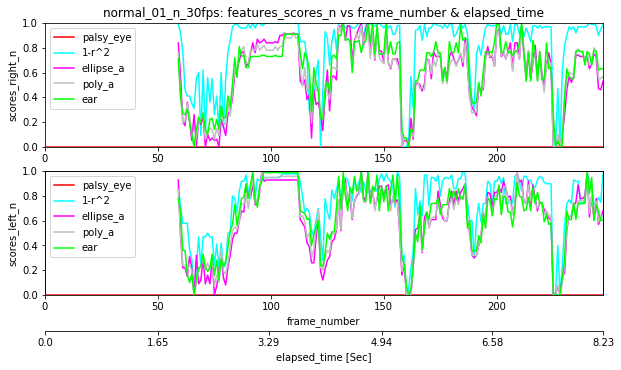

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))

# plot graph for right eye
ax_right = plt.subplot(2,1,1)
# plot features
feature_index = 0
for feature in df_column[1:]:
    df_scores_right_n.plot(kind='line',x='frame_number',y=feature,color=tuple(reversed(np.divide(colors[feature_index],255))),ax=ax_right)
    feature_index = feature_index + 1
# edit titles and axis
plt.title(arg_video_name[:-4]+': features_scores_n vs frame_number & elapsed_time')
plt.xlabel("")
plt.ylabel('scores_right_n')
ax_right.set_xlim([df_frame_number.iloc[0],df_frame_number.iloc[-1]])
ax_right.set_ylim([0,1])

# plot graph for left eye
ax_left = plt.subplot(2,1,2)
# plot features
feature_index = 0
for feature in df_column[1:]:
    df_scores_left_n.plot(kind='line',x='frame_number',y=feature,color=tuple(reversed(np.divide(colors[feature_index],255))),ax=ax_left)
    feature_index = feature_index + 1
# edit titles and axis
plt.ylabel('scores_left_n')
ax_left.set_xlim([df_frame_number.iloc[0],df_frame_number.iloc[-1]])
ax_left.set_ylim([0,1])

# set second x-axis (elapsed_time)
ax2 = ax_left.twiny()
# set the ticklabel position in the second x-axis, then convert them to the position in the first x-axis
ax2_ticks_num = 6
newlabel = [round((x*df_frame_elapsed_time.iloc[-1]/(ax2_ticks_num-1)),precision_digits) for x in range(0, ax2_ticks_num)]
newpos = [int(np.ceil(x*video_fps)) for x in newlabel]
# set the second x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)
ax2.xaxis.set_ticks_position('bottom') 
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('elapsed_time [Sec]')

# save plot to file
plt.savefig(output_path_full+"_scores_graphs.png",bbox_inches='tight',dpi=300)
# show plot
plt.show()